In [21]:

# 必要なライブラリのインポート
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import sem

# 日本語フォント設定
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# 可能であれば日本語フォントを設定
try:
    if os.name == 'posix':  # Mac/Linux
        japanese_fonts = ['Hiragino Sans', 'Hiragino Kaku Gothic Pro', 'Yu Gothic', 'Meiryo']
        for font in japanese_fonts:
            try:
                plt.rcParams['font.family'] = font
                break
            except:
                continue
except:
    pass

# 図のサイズ設定
plt.rcParams['figure.figsize'] = (12, 8)

print("ライブラリのインポートが完了しました")

ライブラリのインポートが完了しました


In [22]:
# データ収集関数
def parse_directory_name(dir_name):
    """
    ディレクトリ名をパースしてcpNum, cpNum_range, cpNum_dirを抽出
    
    Args:
        dir_name: ディレクトリ名（例: "0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1"）
    
    Returns:
        tuple: (cpNum, cpNum_range, cpNum_dir) または (None, None, None)
    """
    params = dir_name.split(',')
    if len(params) < 30:
        return None, None, None
    
    try:
        cpnum = None
        cpnum_range = None
        cpnum_dir = None
        
        # cpNum (0-9番目)
        for i in range(10):
            if int(params[i]) != 0:
                cpnum = int(params[i])
                break
        
        # cpNum_range (10-19番目)
        for i in range(10, 20):
            if int(params[i]) != 0:
                cpnum_range = int(params[i])
                break
        
        # cpNum_dir (20-29番目)
        for i in range(20, 30):
            if int(params[i]) != 0:
                cpnum_dir = int(params[i])
                break
        
        return cpnum, cpnum_range, cpnum_dir
    except (ValueError, IndexError):
        return None, None, None

def collect_data_for_tree_analysis(logs_root='Logs'):
    """
    決定木・ランダムフォレスト用のデータを収集
    パラメータごとに5回実行の結果を集計
    
    Returns:
        pd.DataFrame: 収集したデータ
    """
    data_records = []
    logs_path = Path(logs_root)
    
    # tree=0, tree=500, tree=1000のディレクトリを処理
    for tree_dir in logs_path.glob('tree=*'):
        tree_value = int(tree_dir.name.split('=')[1])
        
        # 各パラメータディレクトリを処理
        for param_dir in tree_dir.iterdir():
            if not param_dir.is_dir():
                continue
            
            # ディレクトリ名をパース
            cpnum, cpnum_range, cpnum_dir = parse_directory_name(param_dir.name)
            if cpnum is None or cpnum_range is None or cpnum_dir is None:
                continue
            
            # ファイルパス
            detected_bugs_path = param_dir / 'detected_bugs.csv'
            exe_time_path = param_dir / 'exe_time.csv'
            
            if not os.path.exists(detected_bugs_path) or not os.path.exists(exe_time_path):
                continue
            
            # detected_bugs.csvの各行を読み込む（各実行ごと）
            bug_results = []
            with open(detected_bugs_path, 'r') as bug_f:
                bug_reader = csv.reader(bug_f)
                for bug_row in bug_reader:
                    if bug_row == ['timeout']:
                        bug_results.append('timeout')
                    elif bug_row == ['null']:
                        bug_results.append('normal')
                    else:
                        bug_results.append('bug')
            
            # 5回実行の結果を集計
            if len(bug_results) >= 5:
                # 最初の5回のみを使用
                first_5_results = bug_results[:5]
                
                # バグ発見の有無（1回でもバグ発見があれば1）
                bug_detected_any = 1 if 'bug' in first_5_results else 0
                
                # 5回全てバグ発見（5回全てbugなら1）
                bug_detected_all = 1 if all(r == 'bug' for r in first_5_results) else 0
                
                
                # データポイントを作成
                data_records.append({
                    'tree': tree_value,
                    'cpNum': cpnum,
                    'cpNum_range': cpnum_range,
                    'cpNum_dir': cpnum_dir,
                    'bug_detected_any': bug_detected_any,  # 1回でもバグ発見
                    'bug_detected_all': bug_detected_all,  # 5回全てバグ発見
                })
    
    df = pd.DataFrame(data_records)
    print(f"データ収集完了: {len(df)}件のレコード")
    print(f"\nデータの基本統計:")
    print(df.describe())
    print(f"\n1回でもバグ発見の分布:")
    print(df['bug_detected_any'].value_counts())
    print(f"\n5回全てバグ発見の分布:")
    print(df['bug_detected_all'].value_counts())
    return df

df_agg = collect_data_for_tree_analysis(logs_root="../Logs/")

データ収集完了: 2160件のレコード

データの基本統計:
              tree        cpNum  cpNum_range    cpNum_dir  bug_detected_any  \
count  2160.000000  2160.000000  2160.000000  2160.000000       2160.000000   
mean    500.000000   225.000000    50.000000     1.150000          0.844444   
std     408.342825   234.059885    40.017597     0.572409          0.362517   
min       0.000000     1.000000     1.000000     1.000000          0.000000   
25%       0.000000    50.000000     1.000000     1.000000          1.000000   
50%     500.000000   149.500000    50.000000     1.000000          1.000000   
75%    1000.000000   300.000000    99.000000     1.000000          1.000000   
max    1000.000000   700.000000    99.000000     4.000000          1.000000   

       bug_detected_all  
count       2160.000000  
mean           0.353241  
std            0.478087  
min            0.000000  
25%            0.000000  
50%            0.000000  
75%            1.000000  
max            1.000000  

1回でもバグ発見の分布:
bug_detec

# タスク2: 5回実行して5回ともバグ発見できるか

## モデルの構築・F値計算

In [23]:

# タスク2: 5回実行して5回ともバグ発見できるかの予測

# 特徴量と目的変数の準備
X = df_agg[['tree', 'cpNum', 'cpNum_range', 'cpNum_dir']]
y = df_agg['bug_detected_all']

# 訓練データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"訓練データ数: {len(X_train)}")
print(f"テストデータ数: {len(X_test)}")
print(f"\n訓練データの目的変数分布:")
print(y_train.value_counts())
print(f"\nテストデータの目的変数分布:")
print(y_test.value_counts())

# 決定木モデルの訓練と評価（タスク2）
# dt_model = DecisionTreeClassifier(
#     max_depth=None,
#     min_samples_leaf=0.05,
#     random_state=42,
#     # class_weight='balanced'
# )
dt_model = DecisionTreeClassifier(
    max_depth=None,
    min_samples_leaf=0.01,
    random_state=42,
    ccp_alpha=0.0, 
    class_weight='balanced',
    criterion='gini',
)
dt_model.fit(X_train, y_train)

# 予測
y2_pred_dt = dt_model.predict(X_test)
y2_pred_proba_dt = dt_model.predict_proba(X_test)[:, 1]

訓練データ数: 1728
テストデータ数: 432

訓練データの目的変数分布:
bug_detected_all
0    1118
1     610
Name: count, dtype: int64

テストデータの目的変数分布:
bug_detected_all
0    279
1    153
Name: count, dtype: int64



【今回のモデル】
Accuracy:  0.7755
Precision: 0.6176
Recall:    0.9608
F1-Score:  0.7519
AUC:       0.8357

【混同行列】
[[188  91]
 [  6 147]]

【ベースラインモデル】
Accuracy:  0.3542
Precision: 0.3542
Recall:    1.0000
F1-Score:  0.5231

【混同行列】
[[  0 279]
 [  0 153]]


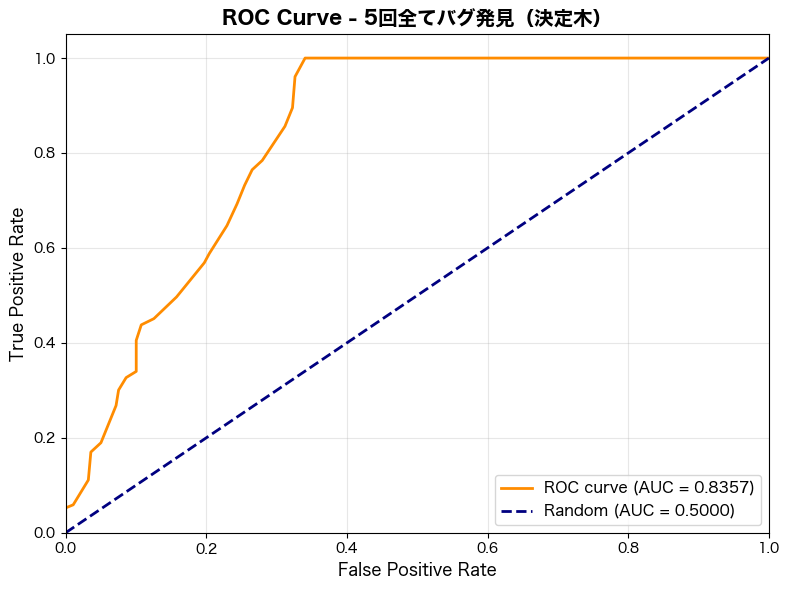

In [24]:

# モデルの評価

# 評価指標
accuracy = accuracy_score(y_test, y2_pred_dt)
precision = precision_score(y_test, y2_pred_dt, zero_division=0)
recall = recall_score(y_test, y2_pred_dt, zero_division=0)
f1 = f1_score(y_test, y2_pred_dt, zero_division=0)

# AUC計算
auc_score = roc_auc_score(y_test, y2_pred_proba_dt)

# 混同行列
cm = confusion_matrix(y_test, y2_pred_dt)

print(f"\n【今回のモデル】")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"AUC:       {auc_score:.4f}")
print("\n【混同行列】")
print(cm)

# ベースラインモデルの予測を作成
y_pred_always_bug = np.ones(len(y_test))

# ベースラインモデルの評価
baseline_accuracy = accuracy_score(y_test, y_pred_always_bug)
baseline_precision = precision_score(y_test, y_pred_always_bug, zero_division=0)
baseline_recall = recall_score(y_test, y_pred_always_bug, zero_division=0)
baseline_f1 = f1_score(y_test, y_pred_always_bug, zero_division=0)

print(f"\n【ベースラインモデル】")
print(f"Accuracy:  {baseline_accuracy:.4f}")
print(f"Precision: {baseline_precision:.4f}")
print(f"Recall:    {baseline_recall:.4f}")
print(f"F1-Score:  {baseline_f1:.4f}")

# 混同行列
cm = confusion_matrix(y_test, y_pred_always_bug)
print("\n【混同行列】")
print(cm)

# ROC曲線の計算と可視化
fpr, tpr, thresholds = roc_curve(y_test, y2_pred_proba_dt)
roc_auc = auc(fpr, tpr)

# ROC曲線のプロット
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random (AUC = 0.5000)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - 5回全てバグ発見（決定木）', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 十分割交差検証

In [25]:

# 交差検証やっていく
# 10分割交差検証の設定（層化サンプリング）
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# 標準化を含むPipelineを作成（交差検証で各foldで標準化を適用）
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('dt', DecisionTreeClassifier(
    max_depth=None,
    min_samples_leaf=0.01,
    random_state=42,
    ccp_alpha=0.0, 
    class_weight='balanced',
    criterion='gini',
))
])

# 評価指標を定義
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

cv_results = cross_validate(
    pipeline, X, y, 
    cv=cv, 
    scoring=scoring,
    return_train_score=False,
    return_estimator=True
)

In [26]:
# 結果の出力
# 10分割交差検証を実行
print("="*70)
print("【5回全てバグ発見】DecisionTreeClassifierによる10分割交差検証")
print("="*70)

# 全体の統計を計算
mean_accuracy = cv_results['test_accuracy'].mean()
std_accuracy = cv_results['test_accuracy'].std()
mean_precision = cv_results['test_precision'].mean()
std_precision = cv_results['test_precision'].std()
mean_recall = cv_results['test_recall'].mean()
std_recall = cv_results['test_recall'].std()
mean_f1 = cv_results['test_f1'].mean()
std_f1 = cv_results['test_f1'].std()
mean_roc_auc = cv_results['test_roc_auc'].mean()
std_roc_auc = cv_results['test_roc_auc'].std()

print("\n【全体の統計（10分割交差検証）】")
print("-"*70)
print(f"Accuracy (正解率):")
print(f"  平均: {mean_accuracy:.4f} ± {std_accuracy:.4f}")
print(f"  範囲: [{cv_results['test_accuracy'].min():.4f}, {cv_results['test_accuracy'].max():.4f}]")

print(f"\nPrecision (適合率):")
print(f"  平均: {mean_precision:.4f} ± {std_precision:.4f}")
print(f"  範囲: [{cv_results['test_precision'].min():.4f}, {cv_results['test_precision'].max():.4f}]")

print(f"\nRecall (再現率):")
print(f"  平均: {mean_recall:.4f} ± {std_recall:.4f}")
print(f"  範囲: [{cv_results['test_recall'].min():.4f}, {cv_results['test_recall'].max():.4f}]")

print(f"\nF1 Score (F値):")
print(f"  平均: {mean_f1:.4f} ± {std_f1:.4f}")
print(f"  範囲: [{cv_results['test_f1'].min():.4f}, {cv_results['test_f1'].max():.4f}]")

print(f"\nAUC (ROC曲線下面積):")
print(f"  平均: {mean_roc_auc:.4f} ± {std_roc_auc:.4f}")
print(f"  範囲: [{cv_results['test_roc_auc'].min():.4f}, {cv_results['test_roc_auc'].max():.4f}]")

# 各フォールドの詳細結果
n_folds = len(cv_results['test_accuracy'])
print("\n【各フォールドの詳細結果】")
print("-"*90)
print(f"{'Fold':<6} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1 Score':<12} {'AUC':<12}")
print("-"*90)
for i in range(n_folds):
    print(f"{i+1:<6} {cv_results['test_accuracy'][i]:<12.4f} {cv_results['test_precision'][i]:<12.4f} {cv_results['test_recall'][i]:<12.4f} {cv_results['test_f1'][i]:<12.4f} {cv_results['test_roc_auc'][i]:<12.4f}")
    
print([round(float(val), 4) for val in cv_results['test_f1']])

【5回全てバグ発見】DecisionTreeClassifierによる10分割交差検証

【全体の統計（10分割交差検証）】
----------------------------------------------------------------------
Accuracy (正解率):
  平均: 0.7981 ± 0.0335
  範囲: [0.7500, 0.8565]

Precision (適合率):
  平均: 0.6412 ± 0.0402
  範囲: [0.5846, 0.7143]

Recall (再現率):
  平均: 0.9882 ± 0.0123
  範囲: [0.9610, 1.0000]

F1 Score (F値):
  平均: 0.7769 ± 0.0284
  範囲: [0.7379, 0.8287]

AUC (ROC曲線下面積):
  平均: 0.8682 ± 0.0215
  範囲: [0.8504, 0.9210]

【各フォールドの詳細結果】
------------------------------------------------------------------------------------------
Fold   Accuracy     Precision    Recall       F1 Score     AUC         
------------------------------------------------------------------------------------------
1      0.7917       0.6379       0.9610       0.7668       0.8577      
2      0.7639       0.6016       1.0000       0.7512       0.8504      
3      0.7685       0.6063       1.0000       0.7549       0.8559      
4      0.8194       0.6637       0.9868       0.7937       0.8703      
5 

## 特徴量重要度の分析

In [27]:
# 交差検証での特徴量重要度を計算
print("="*70)
print("【特徴量重要度（10分割交差検証）】")
print("="*70)

# 各foldの特徴量重要度を取得
feature_importances_cv = []
for estimator in cv_results['estimator']:
    # Pipelineから決定木モデルを取得
    dt_estimator = estimator.named_steps['dt']
    feature_importances_cv.append(dt_estimator.feature_importances_)

# 特徴量重要度をDataFrameに変換
feature_importances_df = pd.DataFrame(
    feature_importances_cv,
    columns=X.columns
)

# 統計を計算
print("\n【各特徴量の重要度統計】")
print("-"*70)
importance_stats = pd.DataFrame({
    '特徴量': X.columns,
    '平均重要度': feature_importances_df.mean().values,
    '標準偏差': feature_importances_df.std().values,
    '最小値': feature_importances_df.min().values,
    '最大値': feature_importances_df.max().values
}).sort_values('平均重要度', ascending=False)
print(importance_stats.to_string(index=False))

# 各foldの特徴量重要度を表示
print("\n【各フォールドの特徴量重要度】")
print("-"*70)
for i, (fold_idx, row) in enumerate(feature_importances_df.iterrows()):
    print(f"\nFold {i+1}:")
    for feature, importance in row.items():
        print(f"  {feature}: {importance:.4f}")

【特徴量重要度（10分割交差検証）】

【各特徴量の重要度統計】
----------------------------------------------------------------------
        特徴量    平均重要度     標準偏差      最小値      最大値
cpNum_range 0.653552 0.007707 0.641875 0.663099
      cpNum 0.332067 0.006886 0.323526 0.341729
       tree 0.014075 0.001743 0.011380 0.016570
  cpNum_dir 0.000306 0.000378 0.000000 0.001190

【各フォールドの特徴量重要度】
----------------------------------------------------------------------

Fold 1:
  tree: 0.0139
  cpNum: 0.3392
  cpNum_range: 0.6463
  cpNum_dir: 0.0006

Fold 2:
  tree: 0.0127
  cpNum: 0.3240
  cpNum_range: 0.6631
  cpNum_dir: 0.0002

Fold 3:
  tree: 0.0156
  cpNum: 0.3311
  cpNum_range: 0.6534
  cpNum_dir: 0.0000

Fold 4:
  tree: 0.0164
  cpNum: 0.3417
  cpNum_range: 0.6419
  cpNum_dir: 0.0000

Fold 5:
  tree: 0.0121
  cpNum: 0.3323
  cpNum_range: 0.6551
  cpNum_dir: 0.0005

Fold 6:
  tree: 0.0145
  cpNum: 0.3413
  cpNum_range: 0.6442
  cpNum_dir: 0.0001

Fold 7:
  tree: 0.0114
  cpNum: 0.3291
  cpNum_range: 0.6593
  cpNum_dir: 0

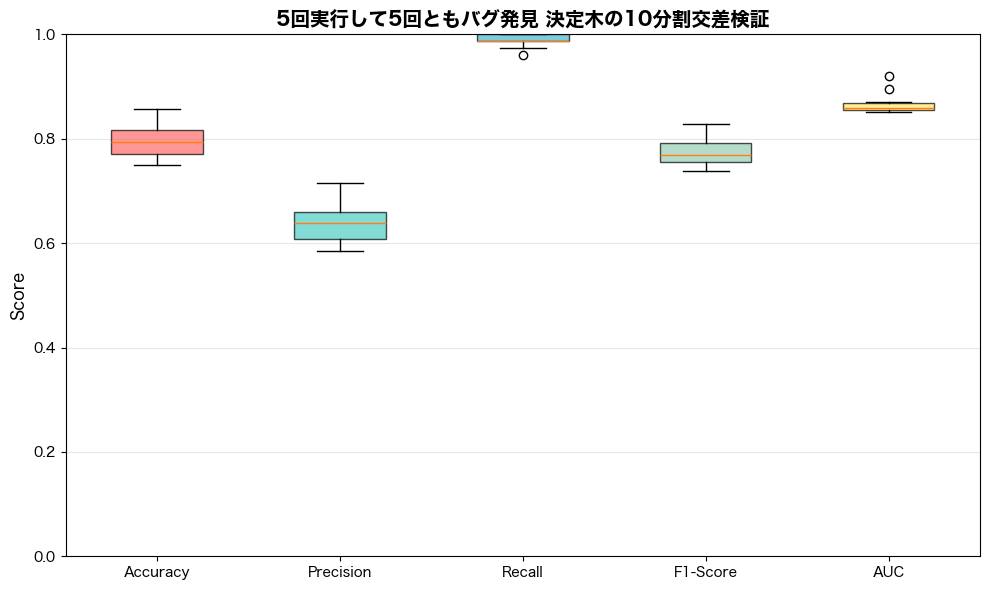

In [28]:
# 交差検証の結果をグラフで表示
# 評価指標のリスト
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']

# 各評価指標のスコアを取得
test_scores = {
    'accuracy': cv_results['test_accuracy'],
    'precision': cv_results['test_precision'],
    'recall': cv_results['test_recall'],
    'f1': cv_results['test_f1'],
    'roc_auc': cv_results['test_roc_auc']
}

# 可視化: 箱ひげ図
_, ax = plt.subplots(figsize=(10, 6))

# テストスコアの箱ひげ図
test_data = [test_scores[m] for m in metrics]
bp = ax.boxplot(test_data, tick_labels=metric_labels, patch_artist=True)
# 箱の色を設定
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFE66D']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax.set_title('5回実行して5回ともバグ発見 決定木の10分割交差検証', fontsize=14, fontweight='bold')
ax.set_ylabel('Score', fontsize=12)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()